**Custom Object Detection by bounding box
-Saif Albuhayder


### **Install Detectron2 & Some Dependencies**





In [1]:
# exit(0)

In [2]:
# !ls /content/drive/MyDrive/content/x/

In [3]:
!pip install pyyaml==5.1
#!pip install torch==1.10.1
!pip install torch==1.10.0+cu111 torchvision==0.11.1+cu111 torchaudio===0.10.0+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html


In [4]:

# TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
# CUDA_VERSION = torch.__version__.split("+")[-1]
# print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)


In [5]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
# exit(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Import Required Libraries**

In [7]:
import torchvision                  #1
import torch                          #2
import matplotlib.pyplot as plt   #5
import os,cv2,random,json     #3
import numpy as np       #4
from detectron2.structures import BoxMode #6
# import some common detectron2 utilities
from detectron2.data import DatasetCatalog, MetadataCatalog  #7
from detectron2.utils.visualizer import Visualizer   #12
from detectron2.config import get_cfg    #11
from detectron2 import model_zoo   #9
from google.colab.patches import cv2_imshow     #8
from detectron2.engine import DefaultPredictor   #10

from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode

#for Evaluate on the test set
# from detectron2.data import build_detection_test_loader
# from detectron2.evaluation import COCOEvaluator
# from detectron2.evaluation import inference_on_dataset

# Unused libraries    saif
# # import other libraries
# import pickle
# from tqdm import tqdm
# from datetime import datetime
# from pathlib import Path
#######################################################################################
# import detectron2
# from detectron2.utils.logger import setup_logger
# setup_logger()


# Train on a custom dataset



## Prepare the dataset

In [8]:
# im = cv2.imread("/content/drive/MyDrive/content/x/test/04.jpg")
# cv2_imshow(im)

### **Registering the data-set to COCO Format**
If the data-set isn't in COCO format i need have to write a method that returns a list of dictionaries with the needed information for Detectron2 to obtain the data

In [9]:
# def get_data_dicts(directory, classes):
#     dataset_dicts = []
    
#     for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
#         json_file = os.path.join(directory, filename)
#         with open(json_file) as f:
#             img_anns = json.load(f)

#         record = {}



#         filename = os.path.join(directory, img_anns["imagePath"])

#         height, width = cv2.imread(filename).shape[:2]  # for flixable dataset resolutions

#         record["file_name"] = filename
#         record["height"] = height
#         record["width"] = width


#         annos = img_anns["shapes"]
#         objs = []
#         for anno in annos:
#             px = [a[0] for a in anno['points']] # x coord
#             py = [a[1] for a in anno['points']] # y-coord
#             poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
#             poly = [p for x in poly for p in x]

#             obj = {
#                 "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
#                 "bbox_mode": BoxMode.XYXY_ABS,
#                 "segmentation": [poly],
#                 "category_id": classes.index(anno['label']),
#                 "iscrowd": 0
#             }
#             objs.append(obj)
#         record["annotations"] = objs
#         dataset_dicts.append(record)
#     return dataset_dicts

In [10]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    id = 0  ############
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        record["image_id"] = id        ################

        filename = os.path.join(directory, img_anns["imagePath"])
        height, width = cv2.imread(filename).shape[:2]  # for flixable dataset resolutions
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        print(record["image_id"])
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]  # x coord
            py = [a[1] for a in anno['points']]  # y-coord
            poly = [(x, y) for x, y in zip(px, py)]  # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        id = id + 1   ######################################
    return dataset_dicts

In [11]:
classes = ['car','pedestrian','truck','bicycle','motorcycle'] 
data_path = '/content/drive/MyDrive/content/w6/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
                          )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144



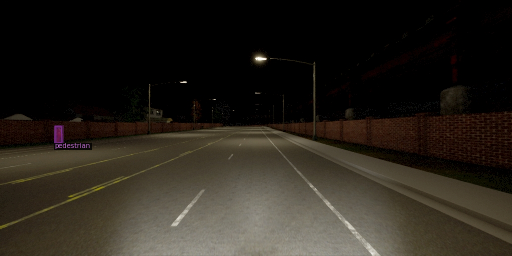

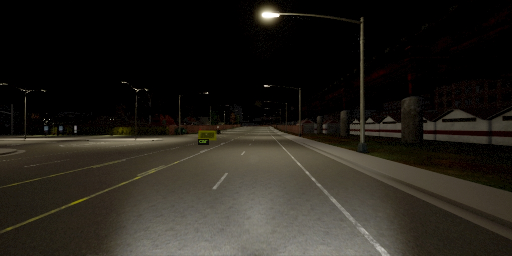

In [12]:
dataset_dicts = get_data_dicts("/content/drive/MyDrive/content/w6/train/",classes)
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    print()
    cv2_imshow(out.get_image()[:, :, ::-1])

In [13]:
# Hyper parameter 
# Create a configuration and set up the model and datasets
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
# cfg.DATASETS.TEST = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2    
cfg.SOLVER.BASE_LR = 0.00025   
cfg.SOLVER.MAX_ITER = 2000     
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  

In [14]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[05/24 14:59:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:02, 93.8MB/s]                          
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pred

###**Inference using the Trained Model**

In [15]:
trainer.train()

[05/24 14:59:26 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/24 14:59:39 d2.utils.events]:  eta: 0:21:42  iter: 19  total_loss: 1.537  loss_cls: 1.083  loss_box_reg: 0.4756  loss_rpn_cls: 0.005426  loss_rpn_loc: 0.006064  time: 0.6501  data_time: 0.0225  lr: 4.9953e-06  max_mem: 3307M
[05/24 14:59:53 d2.utils.events]:  eta: 0:21:36  iter: 39  total_loss: 1.504  loss_cls: 0.9712  loss_box_reg: 0.535  loss_rpn_cls: 0.005777  loss_rpn_loc: 0.01063  time: 0.6589  data_time: 0.0082  lr: 9.9902e-06  max_mem: 3307M
[05/24 15:00:06 d2.utils.events]:  eta: 0:21:35  iter: 59  total_loss: 1.265  loss_cls: 0.7802  loss_box_reg: 0.4107  loss_rpn_cls: 0.01603  loss_rpn_loc: 0.01724  time: 0.6633  data_time: 0.0079  lr: 1.4985e-05  max_mem: 3307M
[05/24 15:00:20 d2.utils.events]:  eta: 0:21:27  iter: 79  total_loss: 0.9945  loss_cls: 0.5413  loss_box_reg: 0.4285  loss_rpn_cls: 0.006915  loss_rpn_loc: 0.01473  time: 0.6675  data_time: 0.0088  lr: 1.998e-05  max_mem: 3307M
[05/24 15:00:34 d2.utils.events]:  eta: 0:21:22  iter: 99  total_loss: 0.9894  loss_cl


### **Testing the Dataset**

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
# Set training data-set path
cfg.DATASETS.TEST = ("category_test", ) 
# Create predictor (model for inference)
predictor = DefaultPredictor(cfg)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


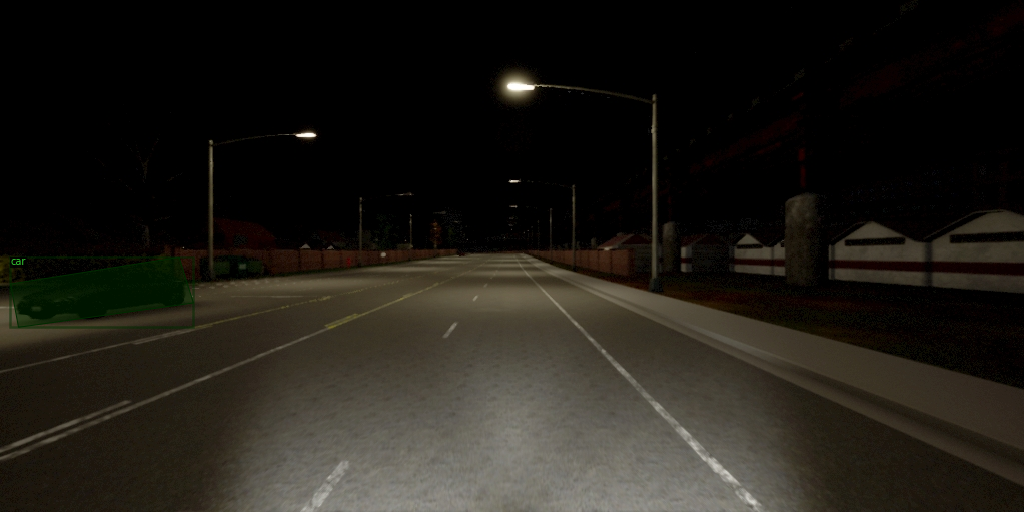

In [17]:
# register valdation or test set 
test_dataset_dicts = get_data_dicts(data_path+'test', classes)
# do visualize for test 
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    # print()
    cv2_imshow(out.get_image()[:, :, ::-1])

we randomly select several samples to visualize the prediction results.

In [1]:
for d in random.sample(test_dataset_dicts, 1):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                  #  instance_mode=ColorMode.IMAGE_BW 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (20, 18))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

NameError: ignored

# Evaluate on the test set (optional)

In [19]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader



# another equivalent way to evaluate the model is to use `trainer.test`

In [20]:
evaluator = COCOEvaluator("category_test", output_dir="./output/")

[05/24 15:22:13 d2.evaluation.coco_evaluation]: Trying to convert 'category_test' to COCO format ...
[05/24 15:22:13 d2.data.datasets.coco]: Converting annotations of dataset 'category_test' to COCO format ...)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
[05/24 15:22:13 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/24 15:22:13 d2.data.datasets.coco]: Conversion finished, #images: 41, #annotations: 64
[05/24 15:22:13 d2.data.datasets.coco]: Caching COCO format annotations at './output/category_test_coco_format.json' ...


In [21]:
val_loader = build_detection_test_loader(cfg, "category_test")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
[05/24 15:22:14 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    car     | 53           | pedestrian | 11           |
|            |              |            |              |
|   total    | 64           |            |              |
[05/24 15:22:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/24 15:22:14 d2.data.common]: Serializing 41 elements to byte tensors and concatenating them all ...
[05/24 15:22:14 d2.data.common]: Serialized dataset takes 0.02 MiB


In [22]:
print(evaluator)

In [23]:
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[05/24 15:22:14 d2.evaluation.evaluator]: Start inference on 41 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[05/24 15:22:16 d2.evaluation.evaluator]: Inference done 11/41. Dataloading: 0.0014 s/iter. Inference: 0.1456 s/iter. Eval: 0.0002 s/iter. Total: 0.1473 s/iter. ETA=0:00:04
[05/24 15:22:21 d2.evaluation.evaluator]: Total inference time: 0:00:05.403692 (0.150103 s / iter per device, on 1 devices)
[05/24 15:22:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.145076 s / iter per device, on 1 devices)
[05/24 15:22:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/24 15:22:21 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[05/24 15:22:21 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/24 15:22:21 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/24 15:22:21 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[05/24 15:22:21 d2.evaluation.

We can also evaluate its performance using AP metric implemented in 
COCO API. This gives an AP of ~70. Not bad!

In [24]:
# f = open('config.yml', 'w')
# f.write(cfg.dump())
# f.close()

In [25]:
# # Evaluate on the test set
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

# predictor = DefaultPredictor(cfg)
# evaluator = COCOEvaluator("category_test", output_dir="./output/")
# print(evaluator)
# val_loader = build_detection_test_loader(cfg,"category_test")
# print(val_loader)
# print(inference_on_dataset(predictor.model, val_loader, evaluator))
# """
# Args:
# img_ids: a list of image IDs to evaluate on. Default to None for the whole dataset
# """

In [26]:
# from tidecv import TIDE, datasets

# tide = TIDE()
# tide.evaluate(datasets.COCO(), datasets.COCOResult('path/to/your/results/file'), mode=TIDE.BOX)
# tide.summarize()  # Summarize the results as tables in the console
# tide.plot()       # Show a summary figure